In [294]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Analyzing Zip decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - Files/folders compressed in zip files have metadata about uncompressed size. How accurate is this?
 - What are the file extensions of the decompressed files?
 - How much of an improvement is estimation vs. decompression?

**Note: Estimation
refers to utilizing the `ZipInfo` object from the `zipfile` library to retrieve uncompressed file size from file headers** 

In [412]:
# Import decompression size .csv
zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")
cdiac_results_df = pd.read_csv("../data/cdiac_zip_results.csv")
cdiac_results_df["origin"] = "cdiac"

# Import decompressed files
zip_decompressed_files = []
with open("../data/zip_decompressed_files.txt") as f:
    for line in f:
        zip_decompressed_files.append(line.rstrip("\n"))

In [413]:
# Summarise data
print(f"{zip_results_df.describe()}\n")

print(f"{len(zip_results_df.index)} files decompressed into {len(zip_decompressed_files)} files\n")
print(f"Compression types: {set(zip_results_df.compression_type)}\n")

       compressed_size  decompressed_size  estimated_value  compression_type  \
count     1.488000e+03       1.488000e+03     1.488000e+03       1488.000000   
mean      4.333157e+07       1.740662e+08     1.740662e+08          7.973118   
std       1.153722e+08       6.261115e+08     6.261115e+08          0.463115   
min       3.505000e+03       1.207600e+04     1.207600e+04          0.000000   
25%       1.753600e+05       4.931322e+05     4.931322e+05          8.000000   
50%       1.413322e+06       4.167147e+06     4.167147e+06          8.000000   
75%       2.204279e+07       5.929530e+07     5.929530e+07          8.000000   
max       8.959300e+08       9.331202e+09     9.331202e+09          8.000000   

       decompression_time  estimation_time  
count         1488.000000      1488.000000  
mean             1.195571         0.000414  
std              4.516032         0.004802  
min              0.000425         0.000080  
25%              0.003729         0.000090  
50%      

Best fit line: 3.8041614143286324x + 9225938.32228703
RMSE: [1.93653214e+08]


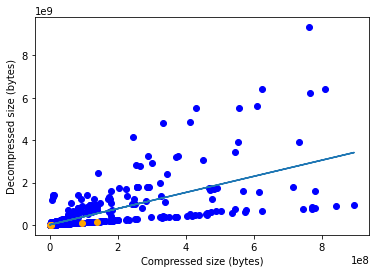

In [414]:
# Visualize compression vs. decompression
x1 = zip_results_df.compressed_size
y1 = zip_results_df.decompressed_size

# Figure 1
coef = np.polyfit(x1, y1, 1)
poly_fn = np.poly1d(coef)
plt.scatter(zip_results_df[zip_results_df.compression_type==8].compressed_size, 
            zip_results_df[zip_results_df.compression_type==8].decompressed_size,
            color="blue")
plt.scatter(zip_results_df[zip_results_df.compression_type==0].compressed_size, 
            zip_results_df[zip_results_df.compression_type==0].decompressed_size,
            color="orange")
plt.plot(x1, poly_fn(x1))

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

Text(0, 0.5, 'Number of files')

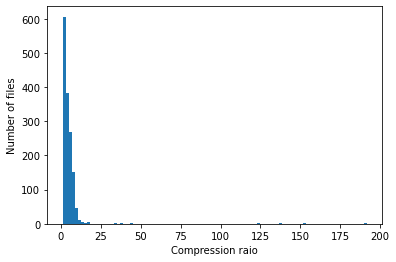

In [418]:
# Visualize compression ratios
compression_ratios = zip_results_df.decompressed_size / zip_results_df.compressed_size

# Figure 2
plt.hist(compression_ratios, bins=100)

plt.xlabel("Compression raio")
plt.ylabel("Number of files")

Best fit line: 0.9999999963421188x + 8.894778079199327


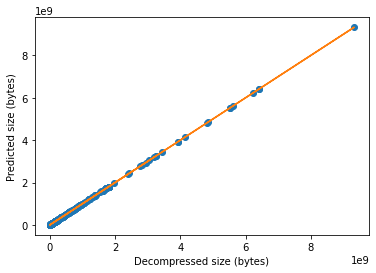

In [419]:
# Visualize actual decompression size vs. predicted size
x2 = zip_results_df.decompressed_size
y2 = zip_results_df.estimated_value

coef = np.polyfit(x2, y2, 1)
poly_fn = np.poly1d(coef)

# Figure 3
plt.plot(x2, y2,"o", x2,  
         poly_fn(x2))

plt.xlabel("Decompressed size (bytes)")
plt.ylabel("Predicted size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")

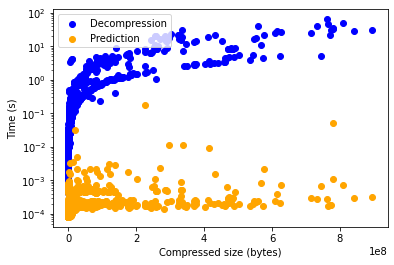

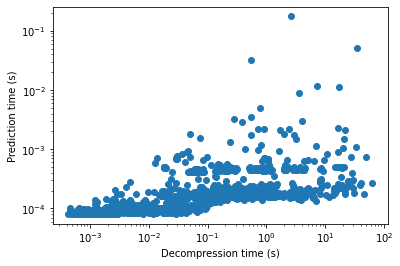

In [420]:
# Visualize compressed size vs. decompression time

x3 = zip_results_df.compressed_size
y3 = zip_results_df.decompression_time
y3_2 = zip_results_df.estimation_time

# Figure 4
plt.scatter(x3, y3, color="blue", label="Decompression")
plt.scatter(x3, y3_2, color="orange", label="Prediction")

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.legend(loc="upper left")
plt.yscale("log")
plt.show()

# Figure 5
plt.scatter(y3, y3_2)
plt.xlabel("Decompression time (s)")
plt.ylabel("Prediction time (s)")
plt.xscale("log")
plt.yscale("log")

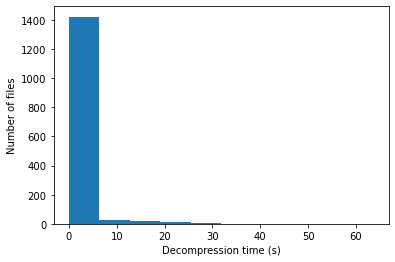

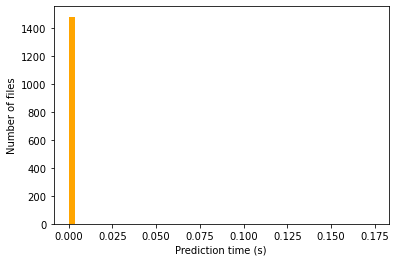

In [421]:
# Visualize decompression and prediction time distributions

# Figure 6
plt.hist(y3)

plt.ylabel("Number of files")
plt.xlabel("Decompression time (s)")
plt.show()

# Figure 7
plt.hist(y3_2, bins=50, color="orange")

plt.ylabel("Number of files")
plt.xlabel("Prediction time (s)")
plt.show()

In [393]:
# Analyze extensions of decompressed files

extensions = [os.path.splitext(file)[1] for file in zip_decompressed_files]
unique_extensions = list(set([extension for extension in extensions if extension != ""]))
extensions_count = [extensions.count(extension) for extension in unique_extensions]

zip_decompressed_extensions_df = pd.DataFrame(data={"extension": unique_extensions, "count": extensions_count})
zip_decompressed_extensions_df.sort_values("count", ascending=False)

,extension,count
41,.mat,5888
11,.dat,4096
87,.tif,3429
62,.xml,3397
153,.hdr,3362
...,...,...
59,.def,1
139,.palm,1
102,.yslogin,1
166,.NewellAurora,1


## Analysis Results:
- The relationship between compressed size and decompressed size looks to be **highly linear**. From Figure 1, we can see that plotting these two values results in two distinct and highly linearly lines. It is still unclear why there are two distinct lines, but it seems unrelated to the compression type of the file.
- A large majority of the files have a ~2:1 ratio (the less steep line in Figure 1)
- Estimation is a **100%** accurate method for determining the final size of decompressed zip files. Figure 3 shows that the the equation of estimated decompressed size vs. true decompressed size is y=x.
- As shown by Figure 4, estimation is **orders of magnitude faster** than decompression. It is also interesting to note that when Figure 4 does not use a log scale for its axis, the decompression times highly resembles Figure 1.
- From Figures 4 and 5, we can see that estimation time has a slight **polynomial correlation** with decompression time.

## Conclusion:
The relationship between the comprsesed and decompressed size of zip files is highly linear. Further analysis could potentially yield multiple linear regressors which are capable of estimating the decompressed size of zip files. However, simply estimating the decompressed size using `ZipInfo` is far more accurate and much faster.

# Analyzing Tar decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - Files/folders compressed in zip files have metadata about uncompressed size. How accurate is this?
 - What are the file extensions of the decompressed files?
 - How much of an improvement is estimation vs. decompression?

**Note: Estimation refers to utilizing the `TarInfo` object from the `tarfile` library to retrieve uncompressed file size from file headers** 

In [443]:
# Import decompression size .csv
tar_results_df = pd.read_csv("../data/tar_decompression_results.csv")

cdiac_tar_results_df = pd.read_csv("../data/cdiac_tar_results.csv")


# Import decompressed files
tar_decompressed_files = []
with open("../data/tar_decompressed_files.txt") as f:
    for line in f:
        tar_decompressed_files.append(line.rstrip("\n"))

In [445]:
# Summarise data
print(f"{tar_results_df.describe()}\n")

print(f"{len(tar_results_df.index)} files decompressed into {len(tar_decompressed_files)} files\n")

       compressed_size  decompressed_size  estimated_value  compression_type  \
count     1.800000e+01       1.800000e+01     1.800000e+01               0.0   
mean      2.818500e+09       8.480523e+09     8.480403e+09               NaN   
std       6.569369e+09       2.195489e+10     2.195494e+10               NaN   
min       2.910800e+04       1.312950e+05     1.312950e+05               NaN   
25%       4.042522e+07       3.997748e+07     3.943417e+07               NaN   
50%       4.412790e+08       8.694000e+08     8.694000e+08               NaN   
75%       1.003851e+09       1.278464e+09     1.278464e+09               NaN   
max       2.083467e+10       6.875089e+10     6.875089e+10               NaN   

       decompression_time  estimation_time  
count           18.000000        18.000000  
mean           166.494743        71.155122  
std            422.407545       177.163842  
min              0.014809         0.000853  
25%              0.158446         0.055447  
50%      

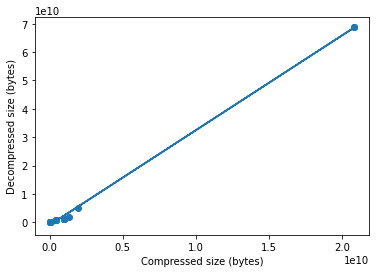

Best fit line: 3.3392765071693975x + -931228171.7964284
RMSE: [8.62582326e+08]
0      4907402374
1      1279795037
2      1253484610
3       768242428
4          131295
5        87334189
6      1274470605
7     68750890720
8      1253523071
9      1786905892
10      767722460
11         137784
12      828911633
13      909888371
14    68744243220
15        5066265
16        7077760
17       24191906
Name: decompressed_size, dtype: int64 [ 5.54638804e+09  2.42111647e+09  2.41631308e+09  4.96353381e+08
 -9.30749453e+08 -6.33677157e+08  2.42027918e+09  6.85027388e+10
  2.41106794e+09  3.38132470e+09  4.95510404e+08 -9.31130972e+08
  5.15017105e+08  5.69631924e+08  6.86414937e+10 -9.14267853e+08
 -9.07565791e+08 -8.50423878e+08]


In [446]:
# Visualize compression vs. decompression
x1 = tar_results_df.compressed_size
y1 = tar_results_df.decompressed_size

# Figure 1
coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)
plt.scatter(x1, y1)
plt.plot(x1, poly_fn(x1))
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")
plt.show()

print(f"Best fit line: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")
print(y1, poly_fn(x1))

Line of best fit: 3.3392765071693975x + -931228171.7964284
RMSE: [0.20147411]


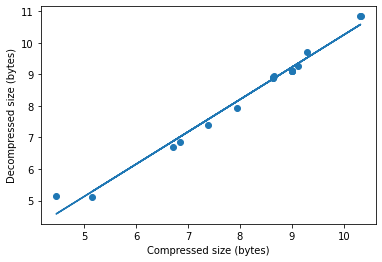

In [447]:
# Figure 2
plt.scatter(np.log10(x1), np.log10(y1))
exp_coef, res, _, _, _ = np.polyfit(np.log10(x1), np.log10(y1), 1, full=True)
exp_poly_fn = np.poly1d(exp_coef)
plt.plot(np.log10(x1), exp_poly_fn(np.log10(x1)))

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

print(f"Line of best fit: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

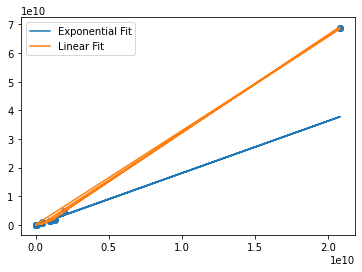

Exponential line of best fit: 10^(1.0251712688024928 * log10(x) + -0.001009358009787757)
Exponential line RMSE: 10337379863.738203
Polynomial line of best fit:             3             2
-4.454e-20 x + 1.069e-09 x + 0.3424 x + 1.081e+08
Linear line RMSE: [2.70823661e+08]


In [450]:
# Figure 3
exp_coef = np.polyfit(np.log10(x1), np.log10(y1), 1)
exp_poly_fn = np.poly1d(exp_coef)
exp_fn = lambda x: np.power(10, exp_poly_fn(np.log10(x)))

plt.scatter(x1, y1)
plt.plot(x1, exp_fn(x1), label="Exponential Fit")

coef, res, _, _, _ = np.polyfit(x1, y1, 3, full=True)
poly_fn = np.poly1d(coef)
plt.plot(x1, poly_fn(x1), label="Linear Fit")
plt.legend()
plt.show()

print(f"Exponential line of best fit: 10^({exp_coef[0]} * log10(x) + {exp_coef[1]})")
print(f"Exponential line RMSE: {np.sqrt((sum(abs(y1 - exp_fn(x1)) ** 2))/len(x1))}")

print(f"Polynomial line of best fit: {poly_fn}")
print(f"Linear line RMSE: {np.sqrt(res/len(x1))}")

Best fit line: 1.0000022259912518x + -139613.1818135672
Estimation RMSE: 495534.83129325265


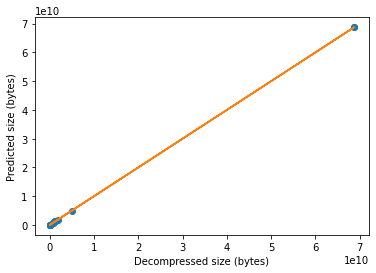

In [449]:
# Visualize actual decompression size vs. predicted size
x2 = tar_results_df.decompressed_size
y2 = tar_results_df.estimated_value

coef, res, _, _, _ = np.polyfit(x2, y2, 1, full=True)
poly_fn = np.poly1d(coef)

# Figure 4
plt.plot(x2, y2,"o", x2,  
         poly_fn(x2))

plt.xlabel("Decompressed size (bytes)")
plt.ylabel("Predicted size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")
print(f"Estimation RMSE: {np.sqrt(sum(abs(y2 - poly_fn(x2))**2)/len(x2))}")

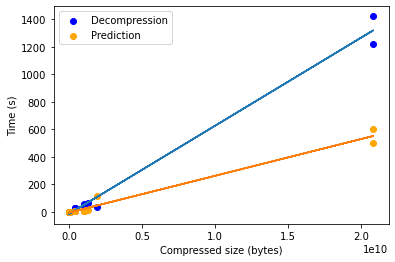

Decompression time best fit line: 6.399353952556436e-08x + -13.871060751176246
Decompression line RMSE: [40.00249823]
Estimation time best fit line: 2.6697786301054862e-08x + -4.092593647687608
Estimation line RMSE: [24.31913758]


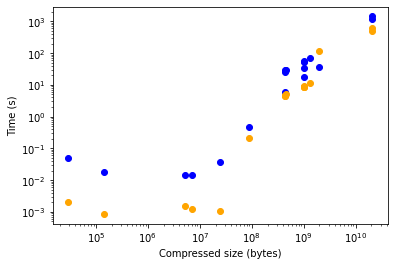

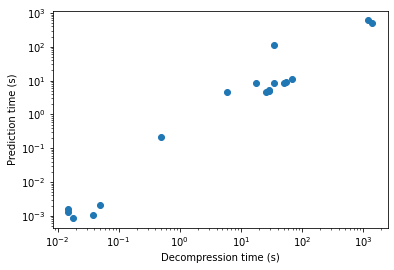

In [451]:
# Visualize compressed size vs. decompression time

x3 = tar_results_df.compressed_size
y3 = tar_results_df.decompression_time
y3_2 = tar_results_df.estimation_time

# Figure 5
decompression_coef, decompression_res, _, _, _ = np.polyfit(x3, y3, 1, full=True)
decompression_poly_fn = np.poly1d(decompression_coef)

estimation_coef, estimation_res, _, _, _ = np.polyfit(x3, y3_2, 1, full=True)
estimation_poly_fn = np.poly1d(estimation_coef)

plt.scatter(x3, y3, color="blue", label="Decompression")
plt.scatter(x3, y3_2, color="orange", label="Prediction")
plt.plot(x3, decompression_poly_fn(x3))
plt.plot(x3, estimation_poly_fn(x3))

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.legend(loc="upper left")
plt.show()

print(f"Decompression time best fit line: {decompression_coef[0]}x + {decompression_coef[1]}")
print(f"Decompression line RMSE: {np.sqrt(decompression_res/len(x3))}")
print(f"Estimation time best fit line: {estimation_coef[0]}x + {estimation_coef[1]}")
print(f"Estimation line RMSE: {np.sqrt(estimation_res/len(x3))}")

# Figure 6
plt.scatter(x3, y3, color="blue", label="Decompression")
plt.scatter(x3, y3_2, color="orange", label="Prediction")

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Figure 6
plt.scatter(y3, y3_2)
plt.xlabel("Decompression time (s)")
plt.ylabel("Prediction time (s)")
plt.xscale("log")
plt.yscale("log")

In [452]:
# Analyze extensions of decompressed files

extensions = [os.path.splitext(file)[1] for file in tar_decompressed_files]
unique_extensions = list(set([extension for extension in extensions if extension != ""]))
extensions_count = [extensions.count(extension) for extension in unique_extensions]

tar_decompressed_extensions_df = pd.DataFrame(data={"extension": unique_extensions, "count": extensions_count})
tar_decompressed_extensions_df.sort_values("count", ascending=False)

,extension,count
8,.dat,20872
284,.txt,2428
523,.pdf,2147
215,.eps,2140
141,.o,396
...,...,...
351,.o8951964,1
500,.o8951940,1
354,.nosnow,1
105,.o8951946,1


## Analysis Results
- The relationship between compressed vs. decompressed size is rather ambiguous. Figure 1 shows a somewhat linear relationship, but the line of best fit has an RMSE of ~8e8, or roughly 800MB. 
- Figure 2 shows an even clearer linear relationship in a log-log plot, with a slope of ~3.4, showing that compressed vs. decompressed size has a cubic or quartic relationship. A quartic regression shows a much improved RMSE of ~2e8, or 200MB. However, many of the data points are located at extremes, so additional data will be needed to confirm this regression
- Figure 3 shows that estimation is a **near perfect** match of the true value. The RMSE of the line of best fit is ~500KB. However, further analysis shows that any error from the line of best fit occurs from one singular point, where estimation underestimated the size of a file by ~2MB, potentially due non-negligible folder sizes not counted when the decompressed size was calculated. 
- Figure 4 shows that estimation is **almost always faster** that decompression, with a linear-looking relation. However, similar to Figures 1 and 2, Figure 5 shows a much stronger linear relation on a log-log plot, indicating another potential polynomial relationship. Many of the estimation times are in the tens or in the hundreds of seconds. Estimation relies on performing a linear scan of the file without decompressing, so it is highly unlikely that this can be parallelized for faster performance. Therefore, for the sake of performance, it may be necessary to create a prediction model. 

## Conclusion
Unlike the estimation of zip file decompressed size, tar file decompressed size is considerably more costly with little hope of being able to be parallelized. Although estimation is a near perfect estimate of decompressed size, there is a massive time tradeoff. In order to find a middleground betweeen accuracy and time, an external polynomial or linear regression may be needed. At this time, decompressed size can be predicted somewhat accurately using a quartic regression. More data will be needed to confirm this relationship and to create a more accurate regression.

# Analyzing Gzip decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - What are the file extensions of the decompressed files?

In [430]:
# Import decompression size .csv
gzip_results_df = pd.read_csv("../data/gzip_decompression_results.csv")

In [431]:
# Data cleaning
gzip_results_df = gzip_results_df[(gzip_results_df.decompressed_size != 0) & (gzip_results_df.compressed_size != 0)]

In [432]:
# Summarise data
print(f"{gzip_results_df.describe()}\n")

       compressed_size  decompressed_size  estimated_value  compression_type  \
count     1.058000e+03       1.058000e+03              0.0               0.0   
mean      2.729036e+07       8.757694e+07              NaN               NaN   
std       2.159935e+08       6.393984e+08              NaN               NaN   
min       1.686400e+04       5.120000e+04              NaN               NaN   
25%       1.610154e+06       6.652087e+06              NaN               NaN   
50%       1.690323e+06       6.941066e+06              NaN               NaN   
75%       1.723998e+06       7.038777e+06              NaN               NaN   
max       4.034568e+09       1.244493e+10              NaN               NaN   

       decompression_time  estimation_time  
count         1058.000000              0.0  
mean             1.281987              NaN  
std             13.389854              NaN  
min              0.000657              NaN  
25%              0.038981              NaN  
50%      

In [433]:
# Visualize compression vs. decompression
x1 = gzip_results_df.compressed_size
y1 = gzip_results_df.decompressed_size

Line of best fit: 2.7548984561003933x + 12394763.269440675
RMSE: [2.33892835e+08]


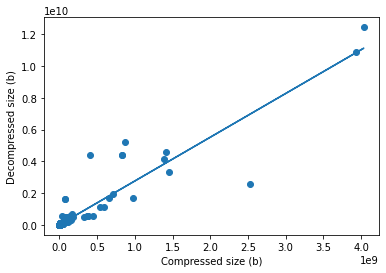

In [434]:
# Figure 1 (Decompressed vs. Compressed size (Linear scale))
plt.scatter(x1, y1)

coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)
plt.plot(x1, poly_fn(x1))

plt.xlabel("Compressed size (b)")
plt.ylabel("Decompressed size (b)")

print(f"Line of best fit: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

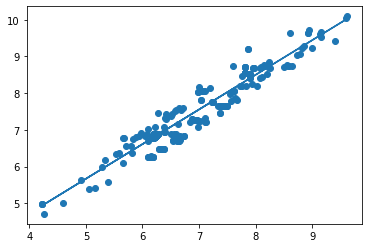

Line of best fit: 0.9441491485044767x + 0.9465445710568757
RMSE: [0.14002054]


In [435]:
# Figure 2 (Decompressed (b) vs. Compressed size (b) (Log10 scale))

plt.scatter(np.log10(x1), np.log10(y1))
coef, res, _, _, _ = np.polyfit(np.log10(x1), np.log10(y1), 1, full=True)
poly_fn = np.poly1d(coef)
plt.plot(np.log10(x1), poly_fn(np.log10(x1)))
plt.show()

print(f"Line of best fit: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

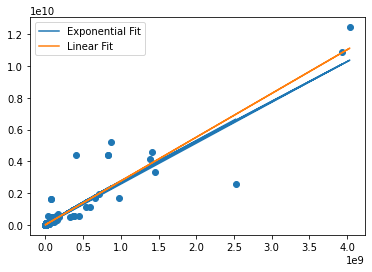

Exponential line of best fit: 10^(0.9441491485044767 * log10(x) + 0.9465445710568757)
Exponential line RMSE: 233596940.9638899
Linear line of best fit: 2.7548984561003933x + 12394763.269440675
Linear line RMSE: [2.33892835e+08]


In [436]:
# Figure 3 (Decompressed vs. Compressed size (Linear scale))

exp_coef = np.polyfit(np.log10(x1), np.log10(y1), 1)
exp_poly_fn = np.poly1d(exp_coef)
exp_fn = lambda x: np.power(10, exp_poly_fn(np.log10(x)))

plt.scatter(x1, y1)
plt.plot(x1, exp_fn(x1), label="Exponential Fit")

coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)
plt.plot(x1, poly_fn(x1), label="Linear Fit")
plt.legend()
plt.show()

print(f"Exponential line of best fit: 10^({exp_coef[0]} * log10(x) + {exp_coef[1]})")
print(f"Exponential line RMSE: {np.sqrt((sum(abs(y1 - exp_fn(x1)) ** 2))/len(x1))}")

print(f"Linear line of best fit: {coef[0]}x + {coef[1]}")
print(f"Linear line RMSE: {np.sqrt(res/len(x1))}")

## Analysis Results
- As shown in Figure 1, it appears that decompressed and compressed size have a linear relationship. This is additionally supported by the fact that the log-log plot in Figure 2 has a slope of ~1. 
- Figure 3 shows that a linear line produces a lower RMSE than an exponential curve. However, the RMSE of the linear regression is ~1.3e9, or 1.3GB. Considering that these decompressed file sizes range from 0-12GB, an average error of 1.3GB is rather significant. More data points will be necessary to fit a better predictor.